<h3 align=center> In His Name, the Most High </h3>

In [1]:
%%capture
!pip install numpy requests nlpaug transformers
!pip install -U sentence-transformers

In [2]:
#importing libraries
import re
import numpy as np
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import AgglomerativeClustering, KMeans
import nlpaug.augmenter.word as naw
import nlpaug.model.word_stats as nmw
from nlpaug.util.file.download import DownloadUtil
import nltk
import pickle
import time  
import random
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
import math
from matplotlib import pyplot as plt
# import gensim.downloader as api

plt.style.use('seaborn')

## ATIS Dataset EDA

The ATIS dataset is a standard benchmark dataset widely used for intent classification and slot filling.
here we obtained the dataset from https://github.com/yvchen/JointSLU.

In [3]:
def dataLoader(filename, drop_list = ['atis_cheapest', 'atis_city', 'atis_restriction', 'atis_meal', 'atis_distance', 'atis_airport', 'atis_capacity', 'atis_ground_fare','atis_flight_no']):
  words_list = list() # a list of list of words for every sentence in dataset
  tags_list = list() # a list of list of IOB tags for every sentence in dataset
  intents_list = list() # a list of intent for every sentence in dataset
  data = list() # a list of dicts contaiting above data in a more structured form
  vocabs = set() # a set containing whole dataset words

  with open(filename) as f:
    for line in f.readlines():
        line = line.strip().split()
        
        index = 0
        words = list()
        for i, word in enumerate(line[:-1]):
            if (word == 'EOS'):
                index = i
                break
            if (word != 'BOS'): 
                # what to do if not word.isalpha()??
                # word = re.sub(r'[^\w\s]', '', word) # removing punctuations
                word = re.sub(r"[?|'|!|.]","", word) # removing punctuations
                word = word.lower() # lowerizing word
                words.append(word) 
                vocabs.add(word)
        
        tags = list()
        for tag in line[index + 2:-1]:
            tags.append(tag)
                    
        # handling entries with multiple intents
        intent = ""
        if ('#' in line[-1]): 
            for item in line[-1].split('#'):
                intent = item
                break
        else: intent = line[-1]

        if (intent not in drop_list): #dropping 
          words_list.append(words)
          tags_list.append(tags)
          intents_list.append(intent)
          data.append({
              'words': words,
              'iob_tags': tags,
              #             'length': len(words),
              'intent': intent})

  return words_list, tags_list, intents_list, vocabs, data


def dataStatistics(tags_list, intents_list, vocabs):
  print('dataset vocab size:', len(vocabs))
  print('# of dataset rows:', len(intents_list))
  print('# of dataset unique intents:', len(set(intents_list)))
  print('# of dataset unique IOB tags:', len(set([tag for item in tags_list for tag in item])))

  print('-' * 35 + '\nintents distribution:') 
  intents_freq = dict()
  for intent in set(intents_list):
      intents_freq[intent] = intents_list.count(intent)
  for key in intents_freq:
      value = intents_freq[key]
      print('%s: %d (%.2f%%),' % (key, value, value / len(intents_list) * 100))
  print()
  plt.figure(figsize=(24, 8))
  plt.bar(list(intents_freq.keys()),intents_freq.values())
  plt.show()

  print('\n' + '-' * 35 + '\ntags distribution:')
  tags_freq = dict()
  count = 0
  for item in tags_list:
      for tag in item:
          if (tag in tags_freq): tags_freq[tag] += 1 
          else: tags_freq[tag] = 1
          count += 1
  for key in tags_freq:
      value = tags_freq[key]
      print('%s: %d (%.2f%%),' % (key, value, value / count * 100))
    
  return intents_freq, tags_freq

dataset vocab size: 895
# of dataset rows: 4860
# of dataset unique intents: 8
# of dataset unique IOB tags: 121
-----------------------------------
intents distribution:
atis_airfare: 424 (8.72%),
atis_flight: 3687 (75.86%),
atis_airline: 159 (3.27%),
atis_aircraft: 82 (1.69%),
atis_quantity: 51 (1.05%),
atis_flight_time: 54 (1.11%),
atis_abbreviation: 147 (3.02%),
atis_ground_service: 256 (5.27%),



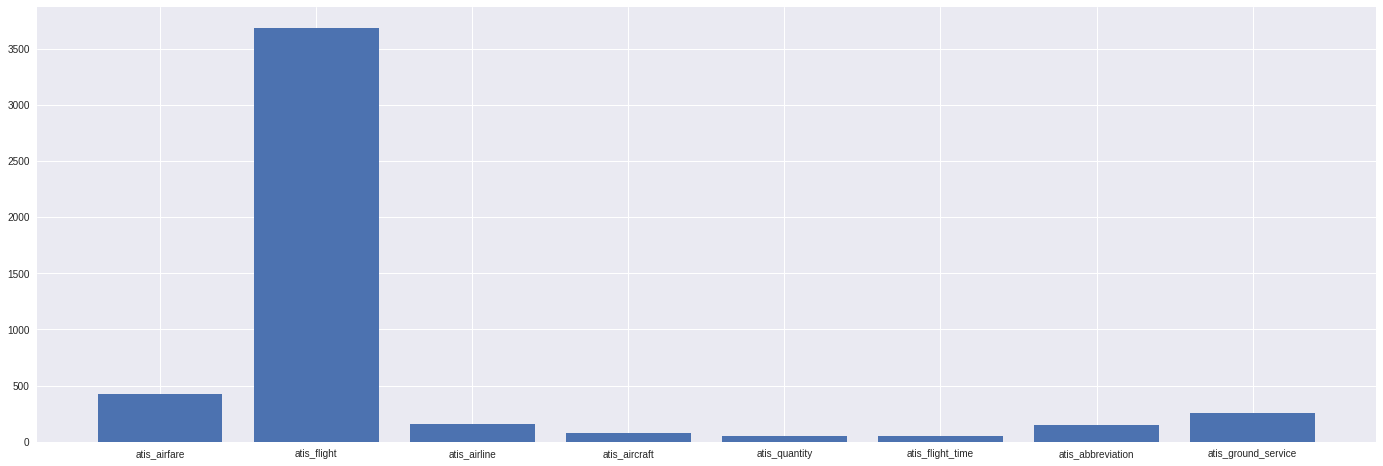


-----------------------------------
tags distribution:
O: 34891 (63.33%),
B-fromloc.city_name: 4294 (7.79%),
B-toloc.city_name: 4308 (7.82%),
B-round_trip: 347 (0.63%),
I-round_trip: 338 (0.61%),
B-cost_relative: 340 (0.62%),
B-fare_amount: 52 (0.09%),
I-fare_amount: 50 (0.09%),
B-arrive_date.month_name: 47 (0.09%),
B-arrive_date.day_number: 47 (0.09%),
I-fromloc.city_name: 684 (1.24%),
B-stoploc.city_name: 238 (0.43%),
B-arrive_time.time_relative: 185 (0.34%),
B-arrive_time.time: 206 (0.37%),
I-arrive_time.time: 160 (0.29%),
B-toloc.state_code: 85 (0.15%),
I-toloc.city_name: 1085 (1.97%),
I-stoploc.city_name: 47 (0.09%),
B-meal_description: 57 (0.10%),
B-depart_date.month_name: 377 (0.68%),
B-depart_date.day_number: 393 (0.71%),
B-airline_name: 681 (1.24%),
I-airline_name: 406 (0.74%),
B-depart_time.period_of_day: 591 (1.07%),
B-depart_date.day_name: 887 (1.61%),
B-toloc.state_name: 76 (0.14%),
B-depart_time.time_relative: 321 (0.58%),
B-depart_time.time: 365 (0.66%),
B-toloc.airport

In [4]:
#importing train data
train_words, train_tags, train_intents, train_vocabs, train_data = dataLoader('atis-2.train+dev.w-intent.iob')
train_intents_freq, train_tags_freq = dataStatistics(train_tags, train_intents, train_vocabs)

In [5]:
ind = 0
print('tokenized words:', train_data[ind]['words'])
print('IOB tags:', train_data[ind]['iob_tags'])
print('intent:', train_data[ind]['intent'])

tokenized words: ['i', 'want', 'to', 'fly', 'from', 'baltimore', 'to', 'dallas', 'round', 'trip']
IOB tags: ['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'B-round_trip', 'I-round_trip']
intent: atis_flight


dataset vocab size: 448
# of dataset rows: 816
# of dataset unique intents: 9
# of dataset unique IOB tags: 98
-----------------------------------
intents distribution:
atis_airfare: 49 (6.00%),
atis_flight: 645 (79.04%),
atis_airline: 38 (4.66%),
atis_day_name: 2 (0.25%),
atis_quantity: 3 (0.37%),
atis_aircraft: 9 (1.10%),
atis_flight_time: 1 (0.12%),
atis_abbreviation: 33 (4.04%),
atis_ground_service: 36 (4.41%),



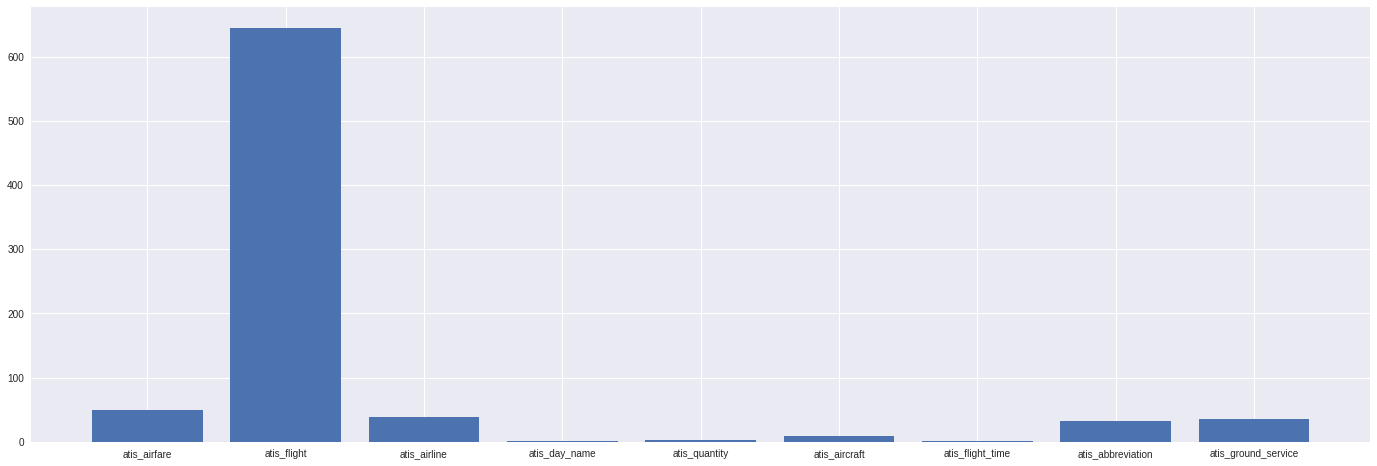


-----------------------------------
tags distribution:
O: 5044 (59.19%),
B-fromloc.city_name: 688 (8.07%),
B-toloc.city_name: 700 (8.21%),
I-toloc.city_name: 256 (3.00%),
B-stoploc.city_name: 20 (0.23%),
I-stoploc.city_name: 10 (0.12%),
B-depart_date.month_name: 56 (0.66%),
B-depart_date.day_number: 55 (0.65%),
B-depart_time.time_relative: 63 (0.74%),
B-depart_time.time: 55 (0.65%),
I-depart_time.time: 50 (0.59%),
B-round_trip: 73 (0.86%),
I-round_trip: 71 (0.83%),
B-airline_name: 87 (1.02%),
I-airline_name: 60 (0.70%),
B-depart_date.day_name: 209 (2.45%),
B-depart_time.period_of_day: 129 (1.51%),
I-fromloc.city_name: 176 (2.07%),
B-meal_description: 9 (0.11%),
B-depart_date.date_relative: 17 (0.20%),
B-arrive_time.time_relative: 31 (0.36%),
B-arrive_time.time: 33 (0.39%),
I-arrive_time.time: 34 (0.40%),
B-return_date.day_name: 2 (0.02%),
B-arrive_date.date_relative: 2 (0.02%),
B-arrive_date.day_name: 11 (0.13%),
B-flight_stop: 21 (0.25%),
B-depart_date.today_relative: 9 (0.11%),
B-to

In [6]:
#importing test data
test_words, test_tags, test_intents, test_vocabs, test_data = dataLoader('atis.test.w-intent.iob')
test_intents_freq, test_tags_freq = dataStatistics(test_tags, test_intents, test_vocabs)

In [7]:
ind = 0
print('tokenized words:', test_data[ind]['words'])
print('IOB tags:', test_data[ind]['iob_tags'])
print('intent:', test_data[ind]['intent'])

tokenized words: ['i', 'would', 'like', 'to', 'find', 'a', 'flight', 'from', 'charlotte', 'to', 'las', 'vegas', 'that', 'makes', 'a', 'stop', 'in', 'st', 'louis']
IOB tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']
intent: atis_flight


##### comparing train & test dataset tags & intents:

In [8]:
print(test_vocabs - train_vocabs)

{'included', 'sb', 'combination', 'not', '1800', '1207', 'ap58', '486', 'good', '608', 'dca', 'bh', 'dc9', 'miles', '639', 'mci', '419', 'india', '20', 'basis', 'dtw', 'exceeding', 'tpa', 'bn', 'yx', '842', 'sam', '320', '468', 'comes', 'called', 'cvg', '1201', 'lga', 'al', 'snacks', '665', 'be1', '1994', 'ever', 'l10', 'phl', 'l1011', '811', 'kennedy', 'dh8', '950', 'kw', 'prior', 'wn', '382', '673'}


In [9]:
set(test_intents) - set(train_intents)

{'atis_day_name'}

so from above, we see there is no train data for 'atis_day_name'...

In [10]:
set(train_intents) - set(test_intents)

set()

and also there are no test data for 'atis_cheapest' & 'atis_restriction'...

In [11]:
set(test_tags_freq.keys()) - set(train_tags_freq.keys())

{'B-booking_class', 'B-compartment', 'B-flight', 'B-stoploc.airport_code'}

also we see there are no train data with 'B-stoploc.airport_code' or 'B-booking_class' or 'I-flight_number' or 'I-state_name' or 'B-flight' or 'B-compartment' tag...

In [12]:
set(train_tags_freq.keys()) - set(test_tags_freq.keys())

{'B-arrive_date.today_relative',
 'B-arrive_time.period_mod',
 'B-day_number',
 'B-month_name',
 'B-return_date.day_number',
 'B-return_date.month_name',
 'B-return_date.today_relative',
 'B-return_time.period_mod',
 'B-return_time.period_of_day',
 'B-state_name',
 'B-stoploc.airport_name',
 'B-stoploc.state_code',
 'B-time',
 'B-time_relative',
 'B-today_relative',
 'I-arrive_date.day_number',
 'I-arrive_time.period_of_day',
 'I-depart_date.today_relative',
 'I-economy',
 'I-fare_basis_code',
 'I-flight_stop',
 'I-meal_code',
 'I-meal_description',
 'I-return_date.day_number',
 'I-return_date.today_relative',
 'I-time',
 'I-today_relative'}

and finally there are no train data with 'I-return_date.day_number' or 'B-return_time.period_mod' or ... tag.

# Handling Imbalanced dataset

to handle imbalanced data first we try to find and remove duplicates:

In [71]:
def removeDuplicate(words_list, tags_list, intents_list):
  words_dup_free = list()
  tags_dup_free = list()
  intents_dup_free = list()
  data_dup_free = list()
  for i in range(len(words_list)):
    words = words_list[i]
    tags = tags_list[i]
    intent = intents_list[i]
    if (intent != 'atis_flight' or (intent == 'atis_flight' and words not in words_dup_free)):
    # if (words not in words_dup_free):
        words_dup_free.append(words)
        tags_dup_free.append(tags)
        intents_dup_free.append(intent)
        data_dup_free.append({
            'words': words,
            'iob_tags': tags,
            #             'length': len(words),
            'intent': intent})
  print('# of duplicate sentences in train data: %d - %d = %d' % (len(words_list), len(words_dup_free), len(words_list) - len(words_dup_free)))

  return words_dup_free, tags_dup_free, intents_dup_free, data_dup_free

In [72]:
#removing duplicate train data  #with 'atis_flight' intent
train_words_dup_free, train_tags_dup_free, train_intents_dup_free, train_data_dup_free = removeDuplicate(train_words, train_tags, train_intents)

# of duplicate sentences in train data: 4860 - 4616 = 244


dataset vocab size: 895
# of dataset rows: 4616
# of dataset unique intents: 8
# of dataset unique IOB tags: 121
-----------------------------------
intents distribution:
atis_airfare: 424 (9.19%),
atis_flight: 3443 (74.59%),
atis_airline: 159 (3.44%),
atis_aircraft: 82 (1.78%),
atis_quantity: 51 (1.10%),
atis_flight_time: 54 (1.17%),
atis_abbreviation: 147 (3.18%),
atis_ground_service: 256 (5.55%),



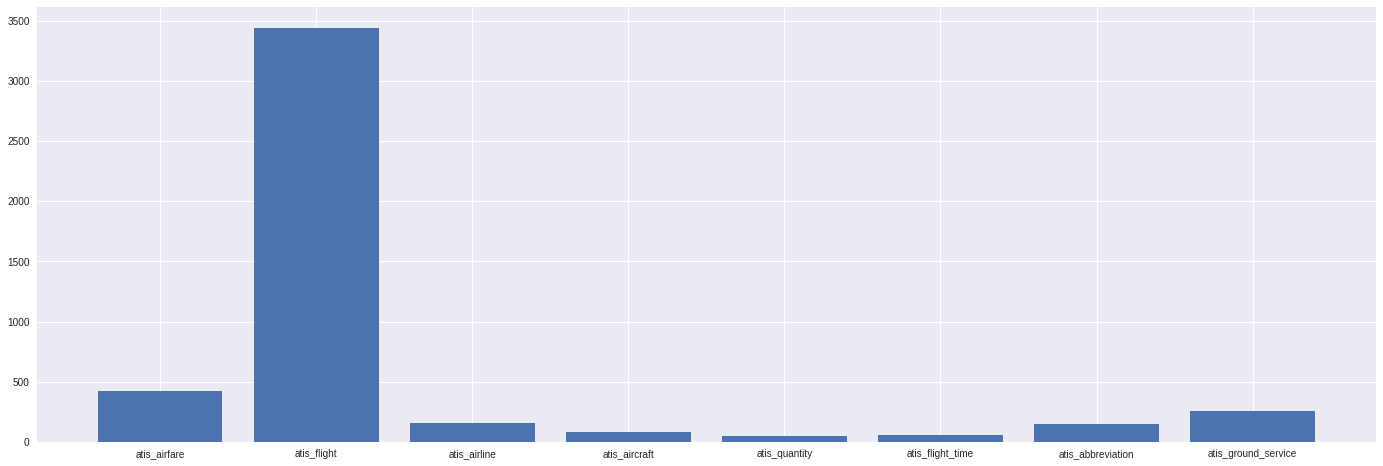


-----------------------------------
tags distribution:
O: 33488 (63.32%),
B-fromloc.city_name: 4064 (7.68%),
B-toloc.city_name: 4076 (7.71%),
B-round_trip: 331 (0.63%),
I-round_trip: 323 (0.61%),
B-cost_relative: 332 (0.63%),
B-fare_amount: 48 (0.09%),
I-fare_amount: 46 (0.09%),
B-arrive_date.month_name: 46 (0.09%),
B-arrive_date.day_number: 46 (0.09%),
I-fromloc.city_name: 650 (1.23%),
B-stoploc.city_name: 232 (0.44%),
B-arrive_time.time_relative: 178 (0.34%),
B-arrive_time.time: 198 (0.37%),
I-arrive_time.time: 155 (0.29%),
B-toloc.state_code: 82 (0.16%),
I-toloc.city_name: 1049 (1.98%),
I-stoploc.city_name: 45 (0.09%),
B-meal_description: 55 (0.10%),
B-depart_date.month_name: 368 (0.70%),
B-depart_date.day_number: 384 (0.73%),
B-airline_name: 668 (1.26%),
I-airline_name: 399 (0.75%),
B-depart_time.period_of_day: 580 (1.10%),
B-depart_date.day_name: 865 (1.64%),
B-toloc.state_name: 74 (0.14%),
B-depart_time.time_relative: 309 (0.58%),
B-depart_time.time: 353 (0.67%),
B-toloc.airport

In [73]:
train_intents_dup_free_freq, train_tags_dup_free_freq = dataStatistics(train_tags_dup_free, train_intents_dup_free, train_vocabs)

In [74]:
##removing duplicate test data with #'atis_flight' intent
test_words_dup_free, test_tags_dup_free, test_intents_dup_free, test_data_dup_free = removeDuplicate(test_words, test_tags, test_intents)

# of duplicate sentences in train data: 816 - 797 = 19


dataset vocab size: 448
# of dataset rows: 797
# of dataset unique intents: 9
# of dataset unique IOB tags: 98
-----------------------------------
intents distribution:
atis_airfare: 49 (6.15%),
atis_flight: 626 (78.54%),
atis_airline: 38 (4.77%),
atis_day_name: 2 (0.25%),
atis_quantity: 3 (0.38%),
atis_aircraft: 9 (1.13%),
atis_flight_time: 1 (0.13%),
atis_abbreviation: 33 (4.14%),
atis_ground_service: 36 (4.52%),



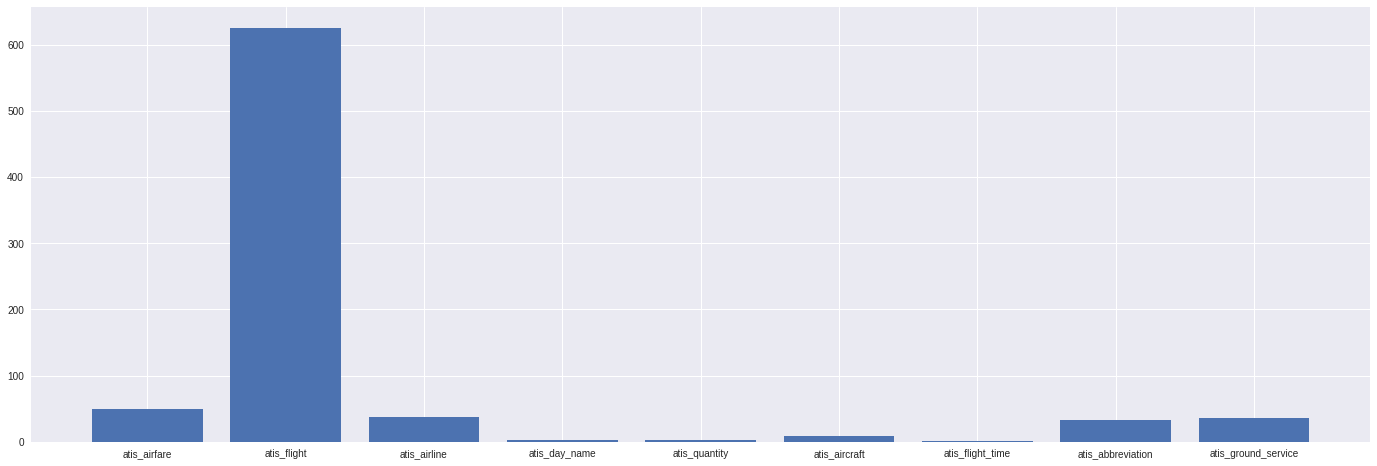


-----------------------------------
tags distribution:
O: 4950 (59.29%),
B-fromloc.city_name: 669 (8.01%),
B-toloc.city_name: 680 (8.14%),
I-toloc.city_name: 249 (2.98%),
B-stoploc.city_name: 20 (0.24%),
I-stoploc.city_name: 10 (0.12%),
B-depart_date.month_name: 56 (0.67%),
B-depart_date.day_number: 55 (0.66%),
B-depart_time.time_relative: 62 (0.74%),
B-depart_time.time: 54 (0.65%),
I-depart_time.time: 49 (0.59%),
B-round_trip: 71 (0.85%),
I-round_trip: 69 (0.83%),
B-airline_name: 87 (1.04%),
I-airline_name: 60 (0.72%),
B-depart_date.day_name: 206 (2.47%),
B-depart_time.period_of_day: 128 (1.53%),
I-fromloc.city_name: 168 (2.01%),
B-meal_description: 9 (0.11%),
B-depart_date.date_relative: 17 (0.20%),
B-arrive_time.time_relative: 31 (0.37%),
B-arrive_time.time: 33 (0.40%),
I-arrive_time.time: 34 (0.41%),
B-return_date.day_name: 2 (0.02%),
B-arrive_date.date_relative: 2 (0.02%),
B-arrive_date.day_name: 11 (0.13%),
B-flight_stop: 21 (0.25%),
B-depart_date.today_relative: 9 (0.11%),
B-to

In [75]:
test_intents_dup_free_freq, test_tags_dup_free_freq = dataStatistics(test_tags_dup_free, test_intents_dup_free, test_vocabs)

so we can see that unfortunately removing duplicates didn't have any noticable improvment on balancing the dataset.

## Classes weights

In [76]:
class_weight.compute_class_weight('balanced',np.unique(train_intents_dup_free) ,train_intents_dup_free)

array([ 3.92517007,  7.03658537,  1.36084906,  3.62893082,  0.16758641,
       10.68518519,  2.25390625, 11.31372549])

##Sentence generation via synonym replacement

In [77]:
def create_iob_file(filename, data):
  f = open(filename, 'w')
  for i in range(len(data)):
    sentence = " ".join(data[i]['words'])
    tags = " ".join(data[i]['iob_tags'])
    intent = data[i]['intent']
    f.write("BOS %s EOS\t%s %s\n" % (sentence, tags, intent))
  f.close()

In [20]:
%%capture
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('stopwords')
nltk.download('wordnet')

# glove = api.load('glove-twitter-25') 
# DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model

stop = nltk.corpus.stopwords.words('english')

# Train TF-IDF model
# tfidf_model = nmw.TfIdf()
# tfidf_model.train(train_words)
# tfidf_model.save('.')

In [21]:
# aug_p=0.25
# aug_max=5
# aug_min=1
# syn = naw.SynonymAug(aug_src='wordnet', stopwords=stop, aug_p=aug_p, aug_max=aug_max, aug_min=aug_min)
# context = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', stopwords=stop, aug_p=aug_p, aug_max=aug_max, aug_min=aug_min, action="substitute")
# emb = naw.WordEmbsAug(model_type='glove', model_path='glove.6B.300d.txt', stopwords=stop, aug_p=aug_p, aug_max=aug_max, aug_min=aug_min, action="substitute")
# # tfidf = naw.TfIdfAug(model_path='.',stopwords=stop, aug_p=aug_p, aug_max=aug_max, aug_min=aug_min,action="substitute")

In [78]:
one_word_cities = set()
two_words_cities = set()
three_words_cities = set()
two_words_city_state = set()

for item in train_data_dup_free:
  i = 0
  while (i < len(item['iob_tags'])):
    if ('city_name' in item['iob_tags'][i]):
      if (i + 2 < len(item['iob_tags'])):
        if ('city_name' in item['iob_tags'][i + 1] and 'city_name' in item['iob_tags'][i + 2]):
            if (item['iob_tags'][i + 1][0] == 'I' and item['iob_tags'][i + 2][0] == 'I'): 
              three_words_cities.add(item['words'][i] + ' ' + item['words'][i + 1] + ' ' + item['words'][i + 2])
              i += 2
      elif (i + 1 < len(item['iob_tags'])):
          if ('city_name' in item['iob_tags'][i + 1] and item['iob_tags'][i + 1][0] == 'I'): 
            two_words_cities.add(item['words'][i] + ' ' + item['words'][i + 1])
            i += 1
          elif ('state_code' in item['iob_tags'][i + 1]): 
            two_words_city_state.add(item['words'][i] + ' ' + item['words'][i + 1])
            i += 1
          elif (item['iob_tags'][i][0] == 'B'): one_word_cities.add(item['words'][i])
      
      elif (item['iob_tags'][i][0] == 'B'): one_word_cities.add(item['words'][i])
    i += 1

In [79]:
one_word_cities = one_word_cities - set(['washington', 'atlantas'])
one_word_cities.update(['ny', 'riverside', 'manhattan', 'ottawa', 'austin', 'bristol', 'appleton', 'Sanford', 'hartford', 'stratford', 'brooklyn', 'queens'])
one_word_cities

{'Sanford',
 'appleton',
 'atlanta',
 'austin',
 'baltimore',
 'boston',
 'bristol',
 'brooklyn',
 'burbank',
 'charlotte',
 'chicago',
 'cincinnati',
 'cleveland',
 'columbus',
 'dallas',
 'denver',
 'detroit',
 'hartford',
 'houston',
 'indianapolis',
 'la',
 'manhattan',
 'memphis',
 'miami',
 'milwaukee',
 'minneapolis',
 'montreal',
 'nashville',
 'newark',
 'ny',
 'oakland',
 'ontario',
 'orlando',
 'ottawa',
 'philadelphia',
 'philly',
 'phoenix',
 'pittsburgh',
 'queens',
 'riverside',
 'seattle',
 'stratford',
 'tacoma',
 'tampa',
 'toronto'}

In [80]:
two_words_cities.update(['santa monica', 'santa barbara', 'oklahoma city', 'new orleans', 'colorado springs', 'port land', 'san antonio'])
two_words_cities

{'bay area',
 'colorado springs',
 'fort worth',
 'kansas city',
 'las vegas',
 'long beach',
 'los angeles',
 'new orleans',
 'new york',
 'oklahoma city',
 'port land',
 'salt lake',
 'san antonio',
 'san diego',
 'san francisco',
 'san jose',
 'santa barbara',
 'santa monica',
 'st louis',
 'st paul',
 'st petersburg',
 'westchester county'}

In [81]:
three_words_cities

{'city in dallas',
 'city of boston',
 'dallas fort worth',
 'new york city',
 'salt lake city'}

In [82]:
two_words_city_state

{'washington dc'}

In [83]:
one_word_states = set()
two_words_states = set()
three_words_states = set()

for item in train_data_dup_free:
  i = 0
  while (i < len(item['iob_tags'])):
    if ('state_name' in item['iob_tags'][i]):
      if (i + 2 < len(item['iob_tags'])):
        if ('state_name' in item['iob_tags'][i + 1] and 'airline_name' in item['iob_tags'][i + 2]):
            if (item['iob_tags'][i + 1][0] == 'I' and item['iob_tags'][i + 2][0] == 'I'): 
              three_words_states.add(item['words'][i] + ' ' + item['words'][i + 1] + ' ' + item['words'][i + 2])
              i += 2
      if (i + 1 < len(item['iob_tags'])):
          if ('state_name' in item['iob_tags'][i + 1] and item['iob_tags'][i + 1][0] == 'I'): 
            two_words_states.add(item['words'][i] + ' ' + item['words'][i + 1])
            i += 1
          elif (item['iob_tags'][i][0] == 'B'): one_word_states.add(item['words'][i])
      elif (item['iob_tags'][i][0] == 'B'): one_word_states.add(item['words'][i])
    i += 1

In [106]:
one_word_states.update(['alabama', 'iowa', 'kentucky', 'oklahoma', 'oregon', 'wisconsin', 'illinois', 'hawaii', 'alaska', 'maryland', 'massachusetts'])
one_word_states.discard('washington')
one_word_states.discard('colorado')
one_word_states

{'alabama',
 'alaska',
 'arizona',
 'california',
 'florida',
 'georgia',
 'hawaii',
 'illinois',
 'indiana',
 'iowa',
 'kentucky',
 'maryland',
 'massachusetts',
 'michigan',
 'minnesota',
 'missouri',
 'nevada',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'quebec',
 'tennessee',
 'texas',
 'utah',
 'wisconsin'}

In [104]:
two_words_states.update(['new hampshire', 'new mexico', 'new york', 'south dakota', 'north dakota', 'south carolina'])
two_words_states.discard('new york')
two_words_states

{'new hampshire',
 'new jersey',
 'new mexico',
 'north carolina',
 'north dakota',
 'south carolina',
 'south dakota'}

In [86]:
three_words_states

set()

In [87]:
one_word_airlines = set()
two_words_airlines = set()
three_words_airlines = set()
for item in train_data_dup_free:
  i = 0
  while (i < len(item['iob_tags'])):
    if ('airline_name' in item['iob_tags'][i]):
      if (i + 2 < len(item['iob_tags'])):
        if ('airline_name' in item['iob_tags'][i + 1] and 'airline_name' in item['iob_tags'][i + 2]):
            if (item['iob_tags'][i + 1][0] == 'I' and item['iob_tags'][i + 2][0] == 'I'): 
              three_words_airlines.add(item['words'][i] + ' ' + item['words'][i + 1] + ' ' + item['words'][i + 2])
              i += 2
      if (i + 1 < len(item['iob_tags'])):
          if ('airline_name' in item['iob_tags'][i + 1] and item['iob_tags'][i + 1][0] == 'I'): 
            two_words_airlines.add(item['words'][i] + ' ' + item['words'][i + 1])
            i += 1
          elif (item['iob_tags'][i][0] == 'B'): one_word_airlines.add(item['words'][i])
      elif (item['iob_tags'][i][0] == 'B'): one_word_airlines.add(item['words'][i])
    i += 1

In [88]:
one_word_airlines.discard('americans')
one_word_airlines.discard('deltas')
one_word_airlines.update(['avelo', 'breeze', 'jetblue', 'spirit'])
one_word_airlines

{'american',
 'avelo',
 'breeze',
 'continental',
 'delta',
 'eastern',
 'jetblue',
 'lufthansa',
 'midwest',
 'nationair',
 'northwest',
 'southwest',
 'spirit',
 'united'}

In [89]:
two_words_airlines.update(['allegiant air', 'frontier airlines'])
two_words_airlines

{'air canada',
 'alaska airlines',
 'allegiant air',
 'america west',
 'american airline',
 'american airlines',
 'canadian airlines',
 'continental airline',
 'continental airlines',
 'delta airline',
 'delta airlines',
 'eastern airline',
 'eastern airlines',
 'frontier airlines',
 'lufthansa airlines',
 'midway airlines',
 'northwest airline',
 'northwest airlines',
 'southwest airlines',
 'tower air',
 'united airline',
 'united airlines',
 'us air',
 'us airlines',
 'usa air'}

In [90]:
three_words_airlines.update(['american eagle airlines', 'sky west airlines', 'omni air international', 'world atlantic airlines'])
three_words_airlines

{'american eagle airlines',
 'canadian airlines international',
 'omni air international',
 'sky west airlines',
 'trans world airline',
 'world atlantic airlines'}

In [91]:
# weekdays = set(['saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday'])
weekdays = set(['saturday', 'sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'sat', 'sun', 'mon', 'tue', 'wed', 'thu', 'fri'])
months = set(['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
daytimes = set(['morning', 'noon', 'afternoon', 'evening', 'night'])
ampm = set(['am', 'pm'])
clocks = set(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])

# second = set(['second', '2nd'])
# third = set(['third', '3rd'])
#ths->seventh, nineteenth ,...


In [92]:
def myAug(sentence, n = 5):
  generated_sentences = list()
  for i in range(n):
    #cities
    new_sentence = sentence
    used_cities = set()
    for city in three_words_cities:
      if (re.search(r'\b%s\b' % (city), new_sentence)):
        # used_cities.add(city)
        new = random.choice(tuple(three_words_cities - used_cities))
        new_sentence = re.sub(r'\b%s\b' % (city) , new, new_sentence)
        used_cities.add(new)
        break
    else:
      # used_cities = set()
      for city in two_words_cities:
        if (re.search(r'\b%s\b' % (city), new_sentence)):
          # used_cities.add(city)
          new = random.choice(tuple(two_words_cities - used_cities))
          new_sentence = re.sub(r'\b%s\b' % (city) , new, new_sentence)
          used_cities.add(new)
      else:
          # used_cities = set()
          for city in one_word_cities:
            if (re.search(r'\b%s\b' % (city), new_sentence)):
              # used_cities.add(city)
              new = random.choice(tuple(one_word_cities - used_cities))
              new_sentence = re.sub(r'\b%s\b' % (city) , new, new_sentence)
              used_cities.add(new)

    #states
    used_states = set()
    for state in three_words_states:
       if (re.search(r'\b%s\b' % (state), new_sentence)):
        # used_states.add(state)
        new = random.choice(tuple(three_words_states - used_states))
        new_sentence = re.sub(r'\b%s\b' % (state) , new, new_sentence)
        used_states.add(new)
        break
    else:
      # used_states = set()
      for state in two_words_states:
        if (re.search(r'\b%s\b' % (state), new_sentence)):
          # used_states.add(state)
          new = random.choice(tuple(two_words_states - used_states))
          new_sentence = re.sub(r'\b%s\b' % (state) , new, new_sentence)
          used_states.add(new)
          # break
      else:
        # used_states = set()
        for state in one_word_states:
          if (re.search(r'\b%s\b' % (state), new_sentence)):
            # used_states.add(state)
            new = random.choice(tuple(one_word_states - used_states))
            new_sentence = re.sub(r'\b%s\b' % (state) , new, new_sentence)
            used_states.add(new)
            # break
      
    #airlines
    used_airlines = set()
    for airline in three_words_airlines:
      if (re.search(r'\b%s\b' % (airline), new_sentence)):
        # used_airlines.add(airline)
        new = random.choice(tuple(three_words_airlines - used_airlines))
        new_sentence = re.sub(r'\b%s\b' % (airline) , new, new_sentence)
        used_airlines.add(new)
        break
    else:
      # used_airlines = set()
      for airline in two_words_airlines:
        if (re.search(r'\b%s\b' % (airline), new_sentence)):
          # used_airlines.add(airline)
          new = random.choice(tuple(two_words_airlines - used_airlines))
          new_sentence = re.sub(r'\b%s\b' % (airline) , new, new_sentence)
          used_airlines.add(new)
          # break
      else:
        # used_airlines = set()
        for airline in one_word_airlines:
          if (re.search(r'\b%s\b' % (airline), new_sentence)):
            # used_airlines.add(airline)
            new = random.choice(tuple(one_word_airlines - used_airlines))
            new_sentence = re.sub(r'\b%s\b' % (airline) , new, new_sentence)
            used_airlines.add(new)
            # break
      
    #months
    # used_months = set()
    for month in months:
      if (re.search(r'\b%s\b' % (month), new_sentence)):
         new = random.choice(tuple(months - set([month])))
         new_sentence = re.sub(r'\b%s\b' % (month) , new, new_sentence)

    #daytimes
    # used_daytimes = set()
    for time in daytimes:
      if (re.search(r'\b%s\b' % (time), new_sentence)):
         new = random.choice(tuple(daytimes - set([time])))
         new_sentence = re.sub(r'\b%s\b' % (time) , new, new_sentence)
          
    #weekdays
    # used_weekdays = set()
    for weekday in weekdays:
      if (re.search(r'\b%s\b' % (weekday), new_sentence)):
         new = random.choice(tuple(weekdays - set([weekday])))
         new_sentence = re.sub(r'\b%s\b' % (weekday) , new, new_sentence)

    #clocks
    # used_clocks = set()
    for clock in clocks:
      if (re.search(r'\b%s\b' % (clock), new_sentence)):
         new = random.choice(tuple(clocks - set([clock])))
         new_sentence = re.sub(r'\b%s\b' % (clock) , new, new_sentence)
         break   
    
    #ampm
    for item in ampm:
      if (re.search(r'\b%s\b' % (item), new_sentence) and random.random() > 0.5):
        new = random.choice(tuple(ampm - set([item])))
        new_sentence = re.sub(r'\b%s\b' % (item) , new, new_sentence)

    if (re.search(r'\b%s\b' % ('first class'), new_sentence) and random.random() > 0.5):
      new_sentence = re.sub(r'\b%s\b' % ('first class') , '1st class', new_sentence)

    if (new_sentence != sentence): generated_sentences.append(new_sentence)
 
  return generated_sentences


# temp = 'nonstop flights from seattle to denver'
# temp = 'i need 2 first class tickets from dallas fort worth to san francisco'
# temp = 'flights from newark new jersey to cleveland'
# temp = 'what flights leave charlotte north carolina and arrive in phoenix arizona on monday before 4 am'
# temp = 'does eastern have a friday afternoon flight from boston to san francisco'
# temp = 'american flights from cincinnati to salt lake city'
# temp = 'show me the cheapest one way flights from pittsburgh to dallas leaving pittsburgh between noon and 2 pm'
# temp = 'afternoon flights from boston to san francisco please that leave in the afternoon'
# temp = 'list all trans world airline flights from indianapolis to tampa that arrive in houston between 1030 am and 1130 am'
# temp = 'flight information on january twenty third 1992 from denver to san francisco'
temp = 'what is the latest flight on wednesday going from atlanta to washington dc'

myAug(temp, n = 5)

['what is the latest flight on tuesday going from tacoma to washington dc',
 'what is the latest flight on sunday going from manhattan to washington dc',
 'what is the latest flight on tuesday going from burbank to washington dc',
 'what is the latest flight on sun going from cleveland to washington dc',
 'what is the latest flight on sat going from philly to washington dc']

In [37]:
f = open('train_data_generated (9).pkl','rb')
new_dict = pickle.load(f)
f.close()
len(new_dict)

126

In [38]:
# train_data_generated = new_dict

In [93]:
train_data_generated_new = list()
starting_index = 0
i = starting_index
for i in range(starting_index, len(train_data_dup_free)):
  if (train_data_dup_free[i]['intent'] != 'atis_flight'):
  # if (train_data_dup_free[i]['intent'] in ['atis_restriction', 'atis_meal', 'atis_capacity', 'atis_ground_fare', 'atis_flight_no', 'atis_airport']):

    orig_sentence = " ".join(train_data_dup_free[i]['words'])
    orig_tags = train_data_dup_free[i]['iob_tags']
    orig_intent = train_data_dup_free[i]['intent']
    # print('\nindex = %d, intent: %s\noriginal sentence: %s\n' % (i, orig_intent, orig_sentence))

    new_sentence = ''
    generated = myAug(orig_sentence, n = 5)
    if(len(generated) > 0): new_sentence = random.choice(tuple(generated))
    # ans = input('\noriginal sentence: %s\nnew sentence: %s\nis it ok? (y or n) ' %(orig_sentence, new_sentence))
    # if (ans.lower() == 'y' or ans.lower() == 'yes'): break
    if (new_sentence != ''):
      new_words = new_sentence.strip().split()
      train_data_generated_new.append({
              'words': new_words,
              'iob_tags': orig_tags,
  #             'length': len(new_words),
              'intent': orig_intent})     
    
    # print('_' * 80)
    # print('# of generated sentences: %d\n' %(len(train_data_generated_new)))
  # i += 1


f = open('train_data_generated_new.pkl','wb')
pickle.dump(train_data_generated_new, f)
f.close()

In [94]:
create_iob_file('atis-generated-new-w-intent.iob', train_data_generated_new)

In [ ]:
# # train_data_generated = list
# starting_index = 2597 
# # 413 -> all except 'atis_flight'
# # 2597 -> just 'atis_restriction', 'atis_meal', 'atis_capacity', 'atis_ground_fare', 'atis_flight_no', 'atis_airport'
# i = starting_index
# while (i < len(train_data_dup_free)):
# # for i in range(starting_index, len(train_data_dup_free)):
#   # if (train_data_dup_free[i]['intent'] != 'atis_flight'):
#   if (train_data_dup_free[i]['intent'] in ['atis_restriction', 'atis_meal', 'atis_capacity', 'atis_ground_fare', 'atis_flight_no', 'atis_airport']):

#     orig_sentence = " ".join(train_data_dup_free[i]['words'])
#     orig_tags = train_data_dup_free[i]['iob_tags']
#     orig_intent = train_data_dup_free[i]['intent']
#     print('\nindex = %d, intent: %s\noriginal sentence: %s\n' % (i, orig_intent, orig_sentence))

#     generated = list()
#     generated += context.augment(orig_sentence, n = 5)
#     generated += emb.augment(orig_sentence, n = 5)
#     generated += syn.augment(orig_sentence, n = 5)
#     for j in range(len(generated)):
#       if (j % 5 == 0): print()
#       print('#%d: %s' % (j, generated[j]))
#     new_sentence = ''
#     while(True):
#       inp = input('\nenter value between 0-'+ str(len(generated) - 1) +' or n to enter new sentence manually, r to regenerate sentences, s to skip sentence or b to break : ')
#       if (inp.isalpha()):
#         if (inp.lower() == 'n'): new_sentence = input('enter new sentence: ')
#         elif (inp.lower() == 'r'):
#           generated = list()
#           generated += context.augment(orig_sentence, n = 5)
#           generated += emb.augment(orig_sentence, n = 5)
#           generated += syn.augment(orig_sentence, n = 5)
#           print('\nindex = %d, intent:%s\noriginal sentence: %s\n' % (i, orig_intent, orig_sentence))
#           for j in range(len(generated)):
#             if (j % 5 == 0): print()
#             print('#%d: %s' % (j, generated[j]))
#           continue

#         elif (inp.lower() == 'b'):
#           print('_' * 80)
#           print('\nlast index = %d\nbreaking...' % (i))
#           i = len(train_data_dup_free)
#           break
        
#         elif (inp.lower() == 's'): break

#         else: continue

#       elif (inp.isnumeric()):
#         inp = int(inp)
#         if(inp > len(generated) - 1): continue
#         new_sentence = generated[inp]

#       else: continue

#       ans = input('\noriginal sentence: %s\nnew sentence: %s\nis it ok? (y or n) ' %(orig_sentence, new_sentence))
#       if (ans.lower() == 'y' or ans.lower() == 'yes'): break
    
#     if (new_sentence != ''):
#       new_words = new_sentence.strip().split()
#       train_data_generated.append({
#               'words': new_words,
#               'iob_tags': orig_tags,
#   #             'length': len(new_words),
#               'intent': orig_intent})     
    
#     print('_' * 80)
#     print('# of generated sentences: %d\n' %(len(train_data_generated)))
#   i += 1


# f = open('train_data_generated.pkl','wb')
# pickle.dump(train_data_generated, f)
# f.close()

In [ ]:
# f = open('train_data_generated.pkl','wb')
# pickle.dump(train_data_generated, f)
# f.close()

In [ ]:
f = open('train_data_generated.pkl','rb')
new_dict = pickle.load(f)
f.close()
len(new_dict)

In [ ]:
# train_data_generated = new_dict

adding some random misspellings

In [ ]:
create_iob_file('atis-generated-w-intent.iob', train_data_generated)

In [ ]:
spell = naw.SpellingAug(dict_path ='spelling_en.txt', aug_p=aug_p, aug_max=aug_max, aug_min=aug_min)

In [41]:
f = open('train_data_misspell (2).pkl','rb')
dict_temp = pickle.load(f)
f.close()
len(dict_temp)

20

In [42]:
# train_data_misspell = dict_temp

In [ ]:
# # train_data_misspell = list()
# starting_index = 1290
# i = starting_index
# while (i < len(train_data_dup_free)):
#   # if (train_data_dup_free[i]['intent'] != 'atis_flight'):
#   # if (train_data_dup_free[i]['intent'] in ['atis_distance', 'atis_restriction', 'atis_city', 'atis_meal', 'atis_capacity', 'atis_ground_fare', 'atis_flight_no', 'atis_flight_time', 'atis_airport', 'atis_quantity']):
#   if (train_data_dup_free[i]['intent'] in ['atis_restriction', 'atis_meal', 'atis_capacity', 'atis_ground_fare', 'atis_flight_no', 'atis_airport']):
#     orig_sentence = " ".join(train_data_dup_free[i]['words'])
#     orig_tags = train_data_dup_free[i]['iob_tags']
#     orig_intent = train_data_dup_free[i]['intent']
#     print('\nindex = %d, intent: %s\noriginal sentence: %s\n' % (i, orig_intent, orig_sentence))

#     generated = spell.augment(orig_sentence, n = 15)
#     for j in range(len(generated)):
#       print('#%d: %s' % (j, generated[j]))
#     new_sentence = ''
#     while(True):
#       inp = input('\nenter value between 0-'+ str(len(generated) - 1) +' or n to enter new sentence manually, r to regenerate sentences, s to skip sentence or b to break : ')
#       if (inp.isalpha()):
#         if (inp.lower() == 'n'): new_sentence = input('enter new sentence: ')
#         elif (inp.lower() == 'r'):
#           generated = spell.augment(orig_sentence, n = 15)
#           print('\nindex = %d, intent:%s\noriginal sentence: %s\n' % (i, orig_intent, orig_sentence))
#           for j in range(len(generated)):
#             print('#%d: %s' % (j, generated[j]))
#           continue

#         elif (inp.lower() == 'b'):
#           print('_' * 80)
#           print('\nlast index = %d\nbreaking...' % (i))
#           i = len(train_data_dup_free)
#           break
        
#         elif (inp.lower() == 's'): break

#         else: continue

#       elif (inp.isnumeric()):
#         inp = int(inp)
#         if(inp > len(generated) - 1): continue
#         new_sentence = generated[inp]

#       else: continue

#       ans = input('\noriginal sentence: %s\nnew sentence: %s\nis it ok? (y or n) ' %(orig_sentence, new_sentence))
#       if (ans.lower() == 'y' or ans.lower() == 'yes'): break
    
#     if (new_sentence != ''):
#       new_words = new_sentence.strip().split()
#       train_data_misspell.append({
#               'words': new_words,
#               'iob_tags': orig_tags,
#   #             'length': len(new_words),
#               'intent': orig_intent})     
    
#     print('_' * 80)
#     print('# of generated sentences: %d\n' %(len(train_data_misspell)))

#   i += 1

# f = open('train_data_misspell.pkl','wb')
# pickle.dump(train_data_misspell, f)
# f.close()

In [ ]:
# f = open('train_data_misspell.pkl','wb')
# pickle.dump(train_data_misspell, f)
# f.close()

In [ ]:
create_iob_file('atis-misspell-w-intent.iob', train_data_misspell)

## SMOTE & ADASYN

In [ ]:
# BoW and Tfidf vectorization

# # from keras.preprocessing.text import Tokenizer
# # from keras.preprocessing.sequence import pad_sequences
# from sklearn.preprocessing import LabelBinarizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import numpy as np

# def identity_tokenizer(text):
#     return text
# # define Tokenizer with Vocab Size
# # tokenizer = Tokenizer(num_words=len(train_vocabs))
# # tokenizer.fit_on_texts(train_words)
# vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer,lowercase=False)
# x_train = vectorizer.fit_transform(train_words)
# x_test = vectorizer.fit_transform(test_words)
# # x_train = tokenizer.texts_to_matrix(train_words, mode='tfidf')
# # x_test = tokenizer.texts_to_matrix(test_words, mode='tfidf')

# encoder = LabelBinarizer()
# encoder.fit(train_intents)
# y_train = encoder.transform(train_intents)
# y_test = encoder.transform(test_intents)
# print(encoder.classes_)
# print(x_train.shape, y_train.shape)


In [ ]:
# from imblearn.over_sampling import SMOTE, ADASYN
# desired_count = 500
# strategy = {0: desired_count, 15: desired_count}# setting atis_restriction and atis_abbreviation classes count just as an example
# smote = ADASYN(sampling_strategy=strategy, n_neighbors=5) #SMOTE(sampling_strategy='minority', k_neighbors=5)
# X_sm, y_sm = smote.fit_resample(x_train, y_train)
# print(X_sm.shape, y_sm.shape)

# y_ADASYN = list(encoder.inverse_transform(y_sm))
# ADASYN_freq = dict()
# for intent in y_ADASYN:
#     ADASYN_freq[intent] = y_ADASYN.count(intent)

# for key in ADASYN_freq:
#     value = ADASYN_freq[key]
#     print('%s: %d (%.2f%%),' % (key, value, value / len(y_ADASYN) * 100))

##Dropping similar sentences

In [43]:
# train sentences with 'atis_flight' intent
train_sentences_dup_free = list()
for i in range(len(train_intents_dup_free)):
  if (train_intents_dup_free[i] == 'atis_flight'): 
    item = " ".join(train_words_dup_free[i]) #stop words?
    train_sentences_dup_free.append(item)

len(train_sentences_dup_free)

3443

In [44]:
corpus_sentences = train_sentences_dup_free
embedder = SentenceTransformer('stsb-mpnet-base-v2') #'paraphrase-mpnet-base-v2'

Downloading:   0%|          | 0.00/868 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.67k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/588 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [45]:
# finding similar pairs

#Compute embeddings
corpus_embeddings = embedder.encode(corpus_sentences,show_progress_bar=True, convert_to_tensor=True)

#Compute cosine-similarities for each sentence with each other sentence
cosine_scores = util.pytorch_cos_sim(corpus_embeddings, corpus_embeddings)

#Find the pairs with the highest cosine similarity scores
pairs = []
for i in range(len(cosine_scores)-1):
    for j in range(i+1, len(cosine_scores)):
        pairs.append({'index': [i, j], 'score': cosine_scores[i][j]})

#Sort scores in decreasing order
pairs = sorted(pairs, key=lambda x: x['score'], reverse=True)

Batches:   0%|          | 0/108 [00:00<?, ?it/s]

In [46]:
f = open('similar-pairs.txt', 'w')
for pair in pairs:
  i, j = pair['index']
  f.write("{} \t\t {} \t\t Score: {:.4f}\n".format(corpus_sentences[i], corpus_sentences[j], pair['score']))
  if (pair['score'] < 0.75): break
f.close()

In [47]:
corpus_sentences = train_sentences_dup_free
corpus_embeddings = embedder.encode(corpus_sentences, show_progress_bar=True)

# Normalize the embeddings to unit length
corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

Batches:   0%|          | 0/108 [00:00<?, ?it/s]

In [ ]:
# # K-means

# num_clusters = 2000
# clustering_model = KMeans(n_clusters=num_clusters)
# clustering_model.fit(corpus_embeddings)
# cluster_assignment = clustering_model.labels_

# clustered_sentences = [[] for i in range(num_clusters)]
# for sentence_id, cluster_id in enumerate(cluster_assignment):
#     clustered_sentences[cluster_id].append(corpus_sentences[sentence_id])

In [ ]:
# reduced_data = PCA(n_components=2).fit_transform(corpus_embeddings)
# kmeans = KMeans(n_clusters=num_clusters)
# kmeans.fit(reduced_data)

# # Step size of the mesh. Decrease to increase the quality of the VQ.
# h = .01     # point in the mesh [x_min, x_max]x[y_min, y_max].

# # Plot the decision boundary. For that, we will assign a color to each
# x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
# y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# # Obtain labels for each point in mesh. Use last trained model.
# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(figsize=(24, 12))
# plt.clf()
# plt.imshow(Z, interpolation="nearest",
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired, aspect="auto", origin="lower")

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)
# # Plot the centroids as a white X
# # centroids = kmeans.cluster_centers_
# # plt.scatter(centroids[:, 0], centroids[:, 1], marker="x", s=169, linewidths=3,
# #             color="w", zorder=10)
# plt.title("K-means clustering (PCA-reduced data)")
#           # "Centroids are marked with white cross")
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
# plt.show()

In [ ]:
# # To get a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions

# fig = plt.figure(1, figsize=(16, 12))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(corpus_embeddings)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],c=kmeans.labels_,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions - Kmeans")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

# plt.show()

In [ ]:
# pca = PCA(n_components=2)
# X_r = pca.fit(corpus_embeddings).transform(corpus_embeddings)


# # Percentage of variance explained for each components
# # print('explained variance ratio (first two components): %s'
# #       % str(pca.explained_variance_ratio_))

# plt.figure(1, figsize=(16, 12))

# for i, target_name in zip([x for x in range(len(kmeans.labels_))], set(kmeans.labels_)):
#     plt.scatter(X_r[kmeans.labels_ == i, 0], X_r[ kmeans.labels_ == i, 1], alpha=.8, label=target_name)
# # plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA K-means')

# plt.show()

In [ ]:
# f = open('Clusters-k-means.txt', 'w')
# for i, cluster in enumerate(clustered_sentences):
#     f.write("Cluster %d, #%d Elements :\n" % (i+1, len(cluster)) + str(cluster) + "\n\n\n")
#     # print("Cluster ", i+1)
#     # print(cluster)
#     # print("")
# f.close()

## Agglomerative Clustering


In [51]:
# clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=1) 
clustering_model = AgglomerativeClustering(n_clusters=None, affinity='cosine', linkage='complete', distance_threshold=0.15)
model = clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences: clustered_sentences[cluster_id] = list()
    clustered_sentences[cluster_id].append(corpus_sentences[sentence_id])

len(clustered_sentences)

2244

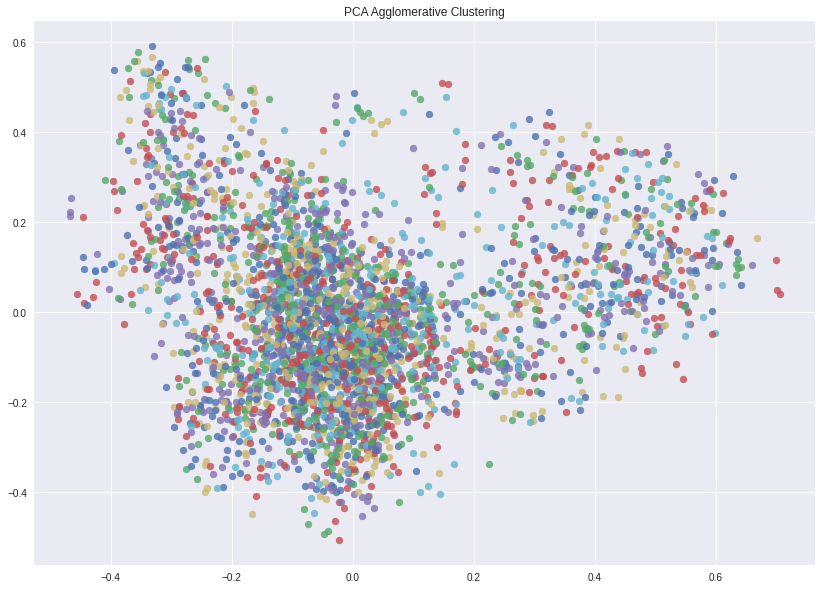

In [52]:
pca = PCA(n_components=2)
X_r = pca.fit(corpus_embeddings).transform(corpus_embeddings)

# Percentage of variance explained for each components
# print('explained variance ratio (first two components): %s'
#       % str(pca.explained_variance_ratio_))

plt.figure(1, figsize=(14, 10))

for i, target_name in zip([x for x in range(len(clustering_model.labels_))], set(clustering_model.labels_)):
    plt.scatter(X_r[clustering_model.labels_ == i, 0], X_r[ clustering_model.labels_ == i, 1], alpha=.8, label=target_name)
# plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA Agglomerative Clustering')

plt.show()

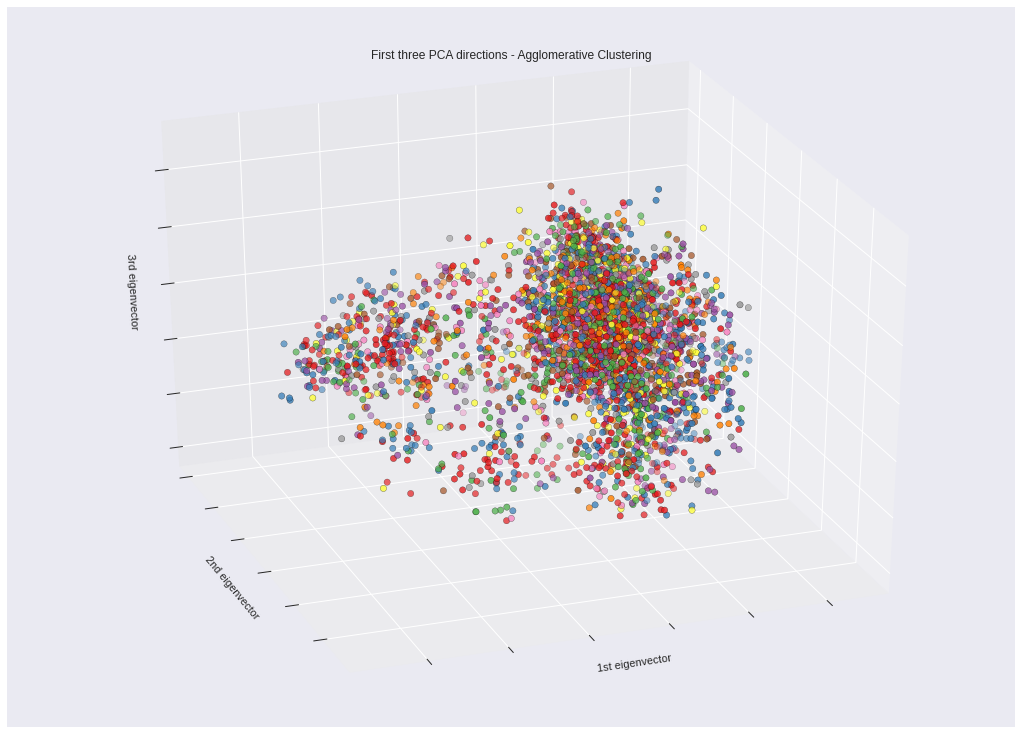

In [53]:
# To get a better understanding of interaction of the dimensions
# plot the first three PCA dimensions

fig = plt.figure(1, figsize=(14, 10))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(corpus_embeddings)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],c=clustering_model.labels_,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions - Agglomerative Clustering")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [54]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

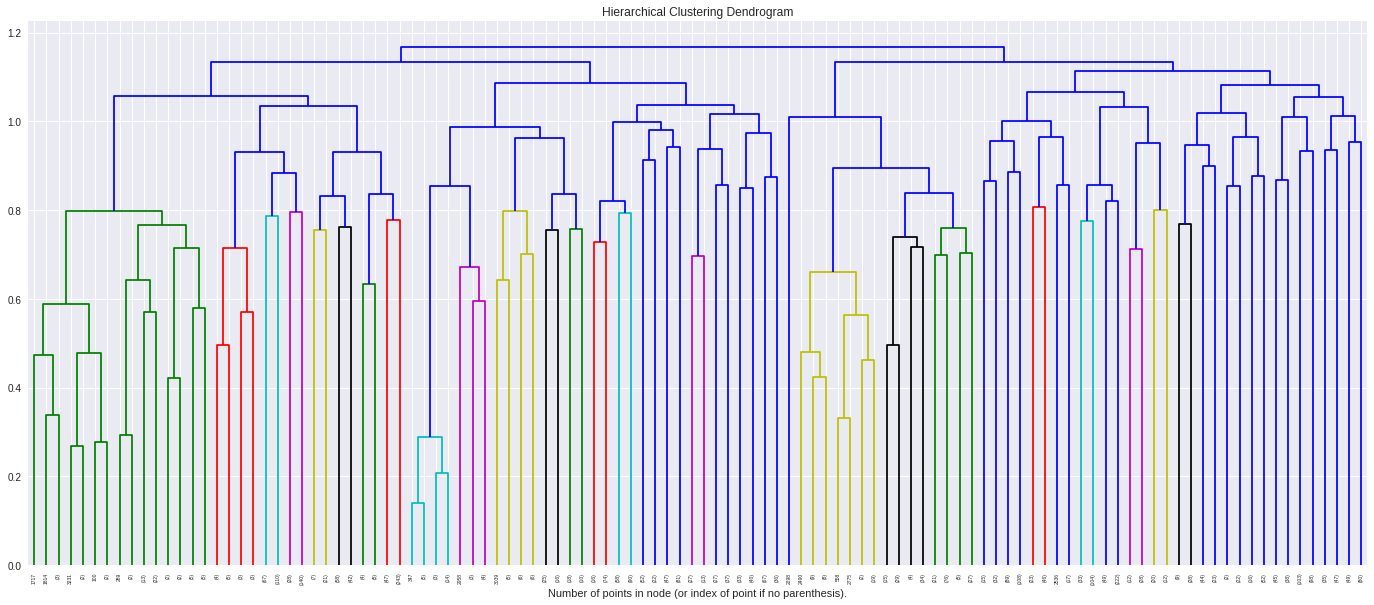

In [55]:
plt.figure(figsize=(24, 10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [56]:
# write to file
f = open('Clusters-Agglomerative.txt', 'w')
for i, cluster in clustered_sentences.items():
    if (len(cluster) > 1): f.write("Cluster %d, #%d Elements :\n" % (i+1, len(cluster)) + str(cluster) + "\n\n\n")
f.close()

In [64]:
percentage = 0.5
train_data_undersampled = list()
for i, cluster in clustered_sentences.items():
  sorted_cluster = sorted(cluster, key=len,  reverse=True)
  for j in range(math.ceil(percentage * len(sorted_cluster))):
     item = next(item for item in train_data_dup_free if item["words"] == sorted_cluster[j].strip().split())
     train_data_undersampled.append(item)     

f = open('train_data_undersampled.pkl','wb')
pickle.dump(train_data_undersampled, f)
f.close()

len(train_data_undersampled)

2554

In [ ]:
f = open('train_data_undersampled.pkl','rb')
new_dict1 = pickle.load(f)
f.close()
len(new_dict1)

2526

In [65]:
create_iob_file('atis-undersampled-w-intent.iob', train_data_undersampled)

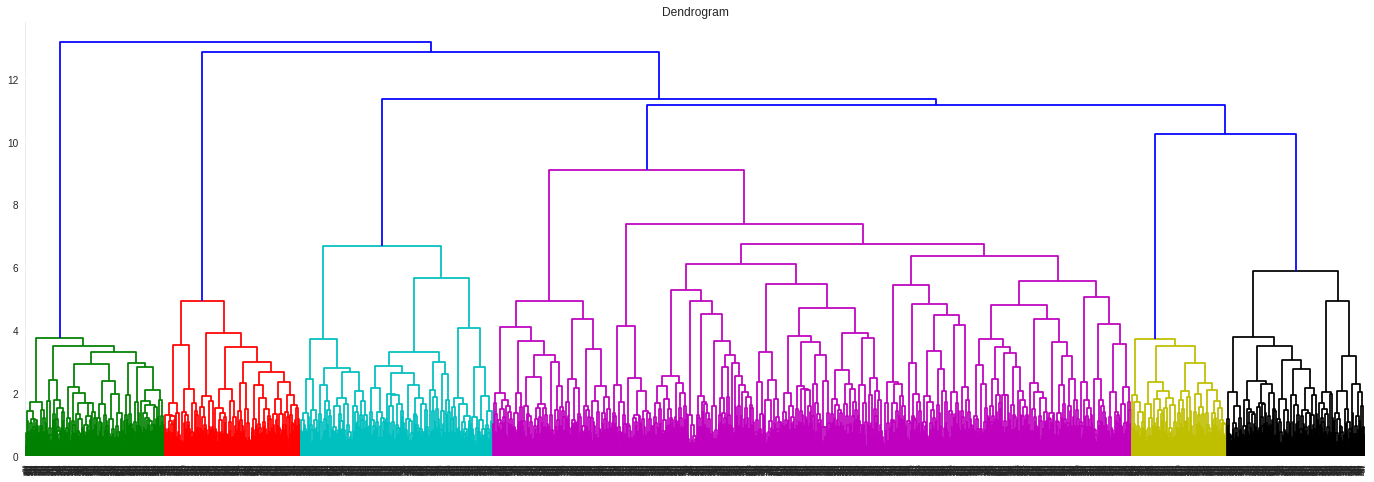

In [ ]:
# import sys
# sys.setrecursionlimit(15000)

Z = hierarchy.linkage(corpus_embeddings, 'ward')
plt.figure(figsize=(24, 8))
plt.title('Dendrogram')
dn = hierarchy.dendrogram(Z)
plt.show()

##Final result

In [95]:
 drop_list = ['atis_cheapest', 'atis_city', 'atis_restriction', 'atis_meal', 'atis_distance', 'atis_airport', 'atis_capacity', 'atis_ground_fare','atis_flight_no']

In [96]:
train_data_final = list()
train_data_final += [item for item in train_data_dup_free if item['intent'] != 'atis_flight']
train_data_final += [item for item in train_data_generated if item['intent'] not in drop_list]
train_data_final += [item for item in train_data_misspell if item['intent'] not in drop_list]
train_data_final += train_data_generated_new
train_data_final += train_data_undersampled
random.shuffle(train_data_final)
create_iob_file('atis-train-final-w-intent.iob', train_data_final)

dataset vocab size: 1002
# of dataset rows: 4771
# of dataset unique intents: 8
# of dataset unique IOB tags: 119
-----------------------------------
intents distribution:
atis_airfare: 874 (18.32%),
atis_flight: 2554 (53.53%),
atis_airline: 293 (6.14%),
atis_aircraft: 161 (3.37%),
atis_quantity: 100 (2.10%),
atis_flight_time: 112 (2.35%),
atis_abbreviation: 152 (3.19%),
atis_ground_service: 525 (11.00%),



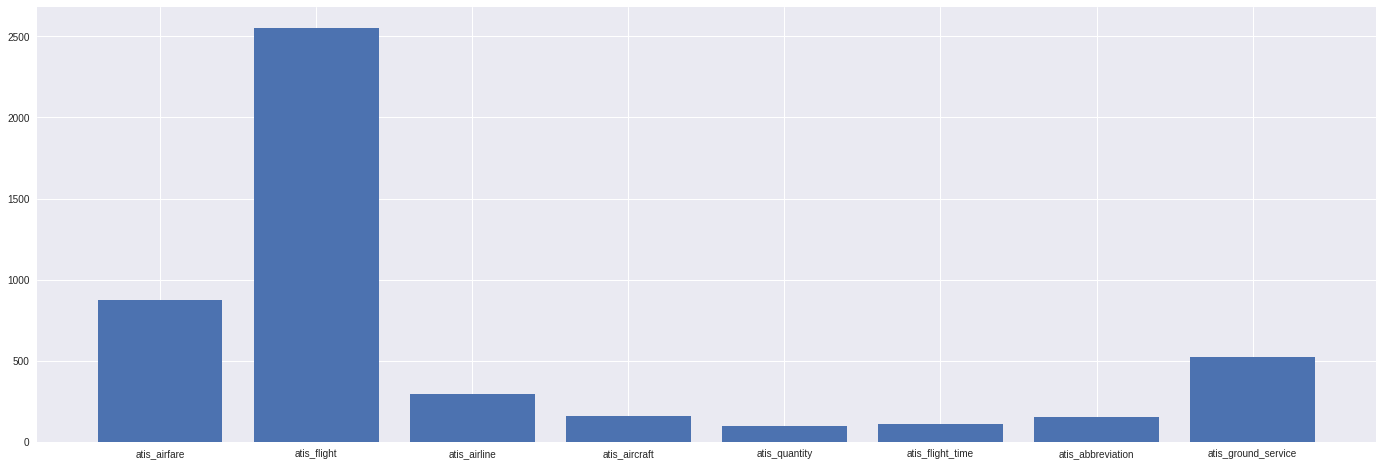


-----------------------------------
tags distribution:
O: 30892 (61.03%),
B-fromloc.city_name: 3910 (7.72%),
B-toloc.city_name: 3958 (7.82%),
B-airline_name: 666 (1.32%),
I-airline_name: 402 (0.79%),
B-depart_time.time: 335 (0.66%),
I-depart_time.time: 272 (0.54%),
B-depart_date.day_name: 712 (1.41%),
B-depart_time.period_of_day: 513 (1.01%),
B-city_name: 393 (0.78%),
B-flight_mod: 250 (0.49%),
B-meal: 36 (0.07%),
I-round_trip: 496 (0.98%),
B-cost_relative: 443 (0.88%),
B-fare_amount: 71 (0.14%),
I-fare_amount: 69 (0.14%),
B-or: 53 (0.10%),
B-round_trip: 462 (0.91%),
I-fromloc.city_name: 602 (1.19%),
B-depart_date.date_relative: 74 (0.15%),
B-fromloc.airport_name: 90 (0.18%),
I-fromloc.airport_name: 110 (0.22%),
B-flight_number: 123 (0.24%),
I-toloc.city_name: 1041 (2.06%),
B-class_type: 311 (0.61%),
I-class_type: 273 (0.54%),
B-depart_time.time_relative: 288 (0.57%),
B-toloc.state_name: 71 (0.14%),
B-stoploc.city_name: 197 (0.39%),
I-cost_relative: 73 (0.14%),
B-fare_basis_code: 79 (

({'atis_abbreviation': 152,
  'atis_aircraft': 161,
  'atis_airfare': 874,
  'atis_airline': 293,
  'atis_flight': 2554,
  'atis_flight_time': 112,
  'atis_ground_service': 525,
  'atis_quantity': 100},
 {'B-aircraft_code': 22,
  'B-airline_code': 141,
  'B-airline_name': 666,
  'B-airport_code': 27,
  'B-airport_name': 50,
  'B-arrive_date.date_relative': 10,
  'B-arrive_date.day_name': 73,
  'B-arrive_date.day_number': 45,
  'B-arrive_date.month_name': 45,
  'B-arrive_date.today_relative': 2,
  'B-arrive_time.end_time': 14,
  'B-arrive_time.period_mod': 4,
  'B-arrive_time.period_of_day': 58,
  'B-arrive_time.start_time': 15,
  'B-arrive_time.time': 170,
  'B-arrive_time.time_relative': 158,
  'B-city_name': 393,
  'B-class_type': 311,
  'B-connect': 36,
  'B-cost_relative': 443,
  'B-day_name': 10,
  'B-day_number': 4,
  'B-days_code': 3,
  'B-depart_date.date_relative': 74,
  'B-depart_date.day_name': 712,
  'B-depart_date.day_number': 403,
  'B-depart_date.month_name': 386,
  'B-d

In [97]:
#importing final result
final_words, final_tags, final_intents, final_vocabs, final_data = dataLoader('atis-train-final-w-intent.iob')
dataStatistics(final_tags, final_intents, final_vocabs)